## Comparison of reference choice

Note, this was run with [this version](https://github.com/matsengrp/multidms/tree/326b036602d58f071c61372f14215d195dee23a3) of `multidms`

**Set the visible devices for GPU training**

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

In [3]:
OUTDIR = "../results/reference_comparison"
FIG_OUTDIR = "../results/manuscript_figures"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

**Read in the dms data and list all available experimental conditions**

In [4]:
func_score_df = pd.read_csv("../data/prepped_func_scores.csv").fillna("")
func_score_df

,func_score,aa_substitutions,condition
0,-0.9244,R214G N439- A846H L1244-,Delta-1
1,0.4364,L10V G75D Y449N R682W A829S A1020D V1228E,Delta-1
2,-1.8556,P25S Y365H A771N S813P,Delta-1
3,-0.0470,R681S,Delta-1
4,1.2236,V70N S98G V143I,Delta-1
...,...,...,...
999050,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2-2
999051,-0.7129,P82S S112T D138T K1038N,Omicron_BA2-2
999052,-0.8500,L179P A222T G261H N405D,Omicron_BA2-2
999053,-2.3933,S27F G413E,Omicron_BA2-2


In [5]:
func_score_df.condition.unique()

array(['Delta-1', 'Delta-2', 'Delta-3', 'Delta-4', 'Omicron_BA1-1',
       'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2'],
      dtype=object)

## Generate Replicate Datasets

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [6]:
datasets = []

**Choose the libraries you would like in each of the two replicates**

In [7]:
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

**Initialize replicate `MultiDmsData` objects**

**Change the datasets colors - the only mutible thing about `MultiDmsData` Objects**

In [10]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040', 
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
# cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
cc = {con:col for con, col in zip(conditions, palette)}


# for data in datasets:
#     data.condition_colors = cc

In [4]:
models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate,reference
0,<multidms.data.MultiDmsData object at 0x7fe5d2...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.2202068786736577, 0.9957886415795965, 0.915...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Delta
1,<multidms.data.MultiDmsData object at 0x7fe5d3...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.1942817009461835, 0.9723563856922917, 0.905...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Delta
2,<multidms.data.MultiDmsData object at 0x7fe518...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0431130631724885, 0.8851882580641597, 0.828...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Omicron_BA1
3,<multidms.data.MultiDmsData object at 0x7fe44c...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0182329451518013, 0.8750387383519955, 0.817...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Omicron_BA1
4,<multidms.data.MultiDmsData object at 0x7fe384...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.009825506220528, 0.858498746562619, 0.81979...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Omicron_BA2
5,<multidms.data.MultiDmsData object at 0x7fe304...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[0.9973539088743184, 0.8560805451049357, 0.796...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Omicron_BA2


In [12]:
# models = pd.DataFrame()
fit_iter = 0

for reference in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    for rep_fsdf, replicate in zip([fs_rep1, fs_rep2], [1, 2]):   
        
        start = time.time()

        # initialize data object
        data = multidms.MultiDmsData(
            rep_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=reference,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=8 
        )
        data.condition_colors = cc

        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")

        fit_params = {
            'init_C_ref' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'conditional_c': True,
            'λ_lasso_shift':5e-05,
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
            'λ_ridge_gamma':1e-3,
            'λ_ridge_ch':1e-3,
            'tol':1e-4,
            'save_model_at':[30000],
            'num_training_steps': 30,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(data, **fit_params)
        model['replicate'] = replicate
        model['reference'] = reference
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/6! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

inferring site map for Delta
inferring site map for Omicron_BA1
inferring site map for Omicron_BA2
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Converting mutations for Delta
is reference, skipping
Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2


Finished, time: 50
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fa0d2e17650>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 1.2202068786736577, Time: 30 Seconds
training_step 1/30, Loss: 0.9957886415795965, Time: 25 Seconds
training_step 2/30, Loss: 0.9159904043628362, Time: 25 Seconds
training_step 3/30, Loss: 0.8777376943192369, Time: 24 Seconds
training_step 4/30, Loss: 0.85387983132794

Converting mutations for Omicron_BA2


Finished, time: 47
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f9ff4ebb7d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 1.1942817009461835, Time: 26 Seconds
training_step 1/30, Loss: 0.9723563856922917, Time: 21 Seconds
training_step 2/30, Loss: 0.905193647748206, Time: 21 Seconds
training_step 3/30, Loss: 0.8666677264323199, Time: 21 Seconds
training_step 4/30, Loss: 0.829282287560293

Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 43
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f9ff4e6ae90>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 1.0431130631724885, Time: 21 Seconds
training_step 1/30, Loss: 0.8851882580641597, Time: 17 Seconds
training_step 2/30, Loss: 0.8287849345584859, Time: 17 Seconds
training_step 3/30, Loss: 0.8056357544016761, Time: 17 Seconds
training_step 4/30, Loss: 0.79170581637341

Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 43
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f9ff3e3b590>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 1.0182329451518013, Time: 21 Seconds
training_step 1/30, Loss: 0.8750387383519955, Time: 17 Seconds
training_step 2/30, Loss: 0.8175075670189158, Time: 17 Seconds
training_step 3/30, Loss: 0.7923302703911375, Time: 17 Seconds
training_step 4/30, Loss: 0.77662759366393

Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2
is reference, skipping
Finished, time: 47
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f9ff30fde10>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 1.009825506220528, Time: 22 Seconds
training_step 1/30, Loss: 0.858498746562619, Time: 18 Seconds
training_step 2/30, Loss: 0.8197933842419217, Time: 18 Seconds
training_step 3/30, Loss: 0.7899339895490749, T

Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2
is reference, skipping
Finished, time: 45
running:
{'PRNGKey': 0,
 'conditional_c': True,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7f86e9c66250>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'init_C_ref': 0.0,
 'iterations_per_step': 1000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 30,
 'output_activation': 'Identity',
 'save_model_at': [30000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 0.0001,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 5e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_ch': 0.001,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/30, Loss: 0.9973539088743184, Time: 21 Seconds
training_step 1/30, Loss: 0.8560805451049357, Time: 17 Seconds
training_step 2/30, Loss: 0.7969906886427114, Time: 17 Seconds
training_step 3/30, Loss: 0.7742409370476679,

In [5]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate,reference
0,<multidms.data.MultiDmsData object at 0x7fe5d2...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.2202068786736577, 0.9957886415795965, 0.915...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Delta
1,<multidms.data.MultiDmsData object at 0x7fe5d3...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.1942817009461835, 0.9723563856922917, 0.905...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Delta
2,<multidms.data.MultiDmsData object at 0x7fe518...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0431130631724885, 0.8851882580641597, 0.828...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Omicron_BA1
3,<multidms.data.MultiDmsData object at 0x7fe44c...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.0182329451518013, 0.8750387383519955, 0.817...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Omicron_BA1
4,<multidms.data.MultiDmsData object at 0x7fe384...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[1.009825506220528, 0.858498746562619, 0.81979...",<multidms.model.MultiDmsModel object at 0x7fd3...,1,Omicron_BA2
5,<multidms.data.MultiDmsData object at 0x7fe304...,1,0.00005,0,0,0.001,0.001,0,Sigmoid,Identity,...,False,0.0001,30,1000,[30000],0,"[0.9973539088743184, 0.8560805451049357, 0.796...",<multidms.model.MultiDmsModel object at 0x7fd3...,2,Omicron_BA2


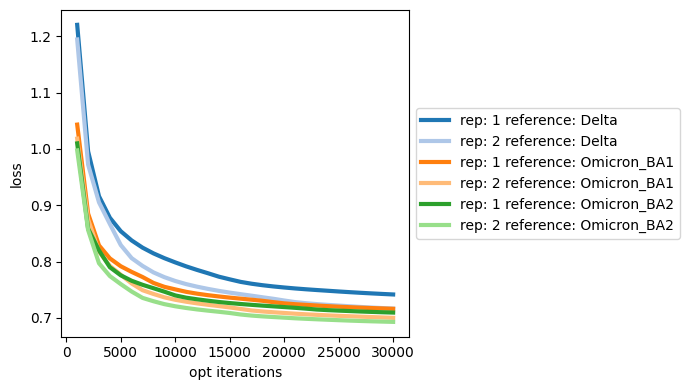

In [6]:
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[7,4])
for i, (model, model_row) in enumerate(models.iterrows()):
    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[i],
        lw=3,
        label=f"rep: {model_row.replicate} reference: {model_row.reference}"
    )

ax.set_ylabel("loss")
ax.set_xlabel("opt iterations")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [7]:
for row_idx, row in models.iterrows():
    data = row.model_30000.params
    pprint.PrettyPrinter(width=20).pprint(data)
    print()
    break

{'C_Delta': Array([0.], dtype=float64),
 'C_Omicron_BA1': Array([-4.82265949], dtype=float64),
 'C_Omicron_BA2': Array([-6.50190838], dtype=float64),
 'C_ref': Array([0.92503134], dtype=float64),
 'S_Delta': Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64),
 'S_Omicron_BA1': Array([ 0.        , -0.        ,  0.        , ...,  0.03001533,
       -0.01377197, -0.        ], dtype=float64),
 'S_Omicron_BA2': Array([ 0.        , -0.        ,  0.        , ..., -0.        ,
        0.08781213,  0.        ], dtype=float64),
 'α': {'ge_bias': Array([-3.42788472], dtype=float64),
       'ge_scale': Array([5.10889806], dtype=float64)},
 'β': Array([-2.60582039, -3.02182448, -2.26964236, ...,  0.53538736,
       -0.07322507,  0.06125358], dtype=float64),
 'γ_Delta': Array([0.], dtype=float64),
 'γ_Omicron_BA1': Array([0.], dtype=float64),
 'γ_Omicron_BA2': Array([0.], dtype=float64)}



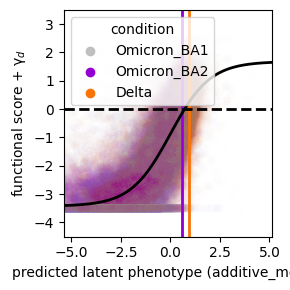

In [8]:
for row_idx, row in models.iterrows():
    model = row.model_30000
    model.plot_epistasis(alpha=0.01)
    
#     pprint.PrettyPrinter(width=20).pprint(data)
#     print()
    break

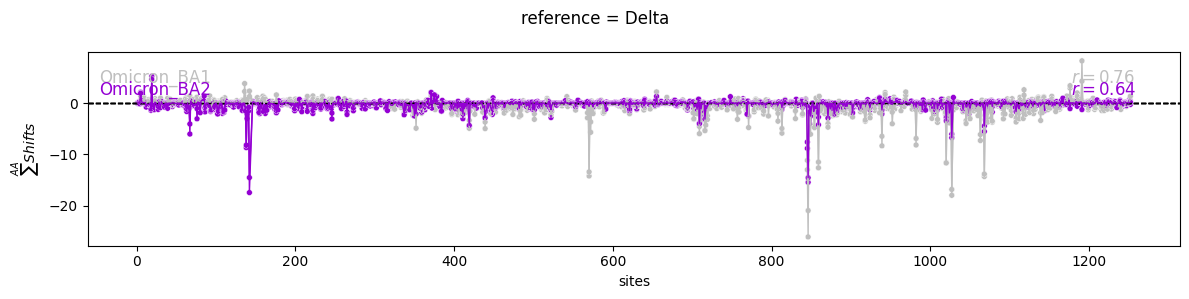

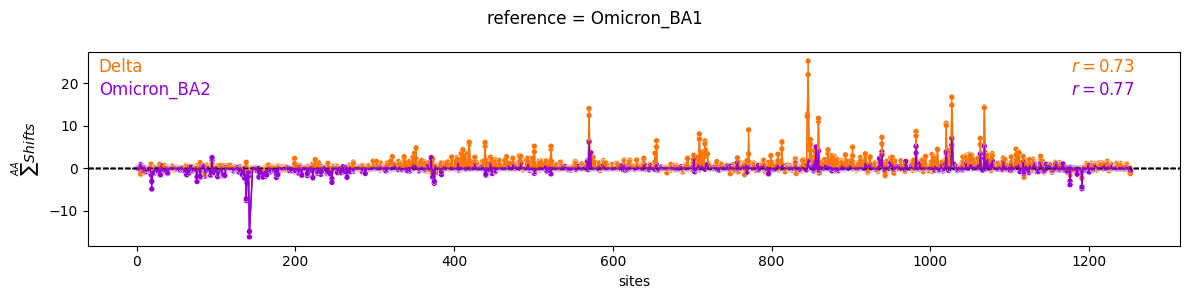

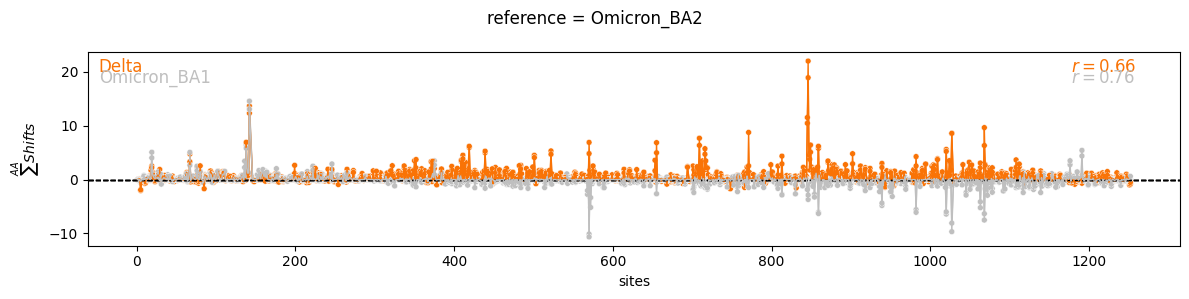

In [9]:
for i, (reference, reference_replicates) in enumerate(models.groupby("reference")):
    i=0
    fig, ax = plt.subplot_mosaic(
        """
        SSSS
        SSSS
        """,
        figsize=[12,3]
    )
    
    fit_dict = {}
    for _, row in reference_replicates.iterrows():
        replicate = row.replicate
        model = row.model_30000
        fit_dict[f"{replicate}"] = model
        
        for b, cond in enumerate(model.data.conditions):
            
            if cond == model.data.reference: continue
            model.plot_shifts_by_site(
                cond, 
                show=False, 
                agg_func=onp.sum, 
                times_seen_threshold=3, 
                ax=ax[f"S"], 
                lw=1
            )
    muts_df_outer = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="outer")
    muts_df_inner = muts_df_outer.dropna()
    for b, cond in enumerate(model.data.conditions):
        if cond == model.data.reference: continue 
        corr = pearsonr(muts_df_inner[f"1_S_{cond}"], muts_df_inner[f"2_S_{cond}"])[0]
        ax[f"S"].annotate(
            f"$r = {corr:.2f}$", 
            (0.9, (0.9 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
        ax[f"S"].annotate(
            cond, 
            (0.01, (0.90 - (b*0.06))), 
            xycoords="axes fraction", 
            fontsize=12,
            c = model.data.condition_colors[cond]
        )
        
    ax[f"S"].set_ylabel("$\sum^{AA} Shifts$")
    
    fig.suptitle(f"reference = {reference}")
    plt.tight_layout()
    
    plt.show()

As an example, take the fit where Delta is the reference. I'd first compute beta_d,m params, where:
```
beta_Delta,m = beta_m
beta_BA.1,m = beta_m + s_BA.1,m
beta_BA.2,m = beta_m + s_BA.2,m
```
Then I'd compute shifts relative to BA.1 as:
```
s_Delta,m = beta_Delta,m - beta_BA.1,m
s_BA.2,m = beta_BA.2,m - beta_BA.1,m = (beta_m + s_BA.2,m) - (beta_m + s_BA.1,m)
```
I'd do the same thing for BA.2 as the reference. So for each reference fit, you'd get a set of  beta_BA.1,m, s_Delta,m, and s_BA.2,m parameters, which you could use to make correlation plots.

In [10]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [11]:
relative_params = pd.DataFrame()
homologs = ["Delta", "Omicron_BA1", "Omicron_BA2"]

# For each respective model fit 
for reference, replicate_models in models.groupby("reference"):
    
    # combine the replicate mutational 
    mut_df = multidms.utils.combine_replicate_muts(
        {
            f"rep_{row.replicate}":row["model_30000"] 
            for idx, row in replicate_models.iterrows()
        },
        times_seen_threshold = 1
    )
    
    mut_df = mut_df.copy()[[c for c in mut_df.columns if "avg" in c]]
    
    # Compute mut effect (beta+shift) relative to each homolog
    for homolog in homologs:
        if homolog == reference:
            mut_df[f"β_{homolog}"] = mut_df["avg_β"]
        else:
            mut_df[f"β_{homolog}"] = mut_df["avg_β"] + mut_df[f"avg_S_{homolog}"]
       
    # Compute shifts relative to BA1 (betas_h - beta_BA1)
    for homolog in homologs:
        mut_df[f"S_{homolog}"] = mut_df[f"β_{homolog}"] - mut_df[f"β_Omicron_BA1"]
    
    # drop un-neccessary columns
    mut_df.drop([c for c in mut_df.columns if "avg" in c], axis=1, inplace=True)
    
    mut_df = mut_df.assign(reference = reference)
    
    relative_params = pd.concat([relative_params, mut_df])

    
relative_params.drop(["β_Delta", "β_Omicron_BA2", "S_Omicron_BA1"], axis=1, inplace=True)
relative_params.reference.replace({"Omicron_BA2":"BA2", "Omicron_BA1": "BA1"}, inplace=True)
relative_params

,β_Omicron_BA1,S_Delta,S_Omicron_BA2,reference
mutation,,,,
M1I,-3.392746,0.000000,0.000000,Delta
F2L,0.228677,0.000000,-0.064132,Delta
F2S,0.143352,0.000000,0.000000,Delta
F2V,0.314621,0.000000,0.000000,Delta
V3A,-0.054190,-0.014244,-0.014244,Delta
...,...,...,...,...
S1252T,-0.152548,-0.028114,-0.028114,BA2
S1252V,0.151697,0.025453,-0.061956,BA2
S1252W,0.181581,0.000000,0.000000,BA2


β_Omicron_BA1


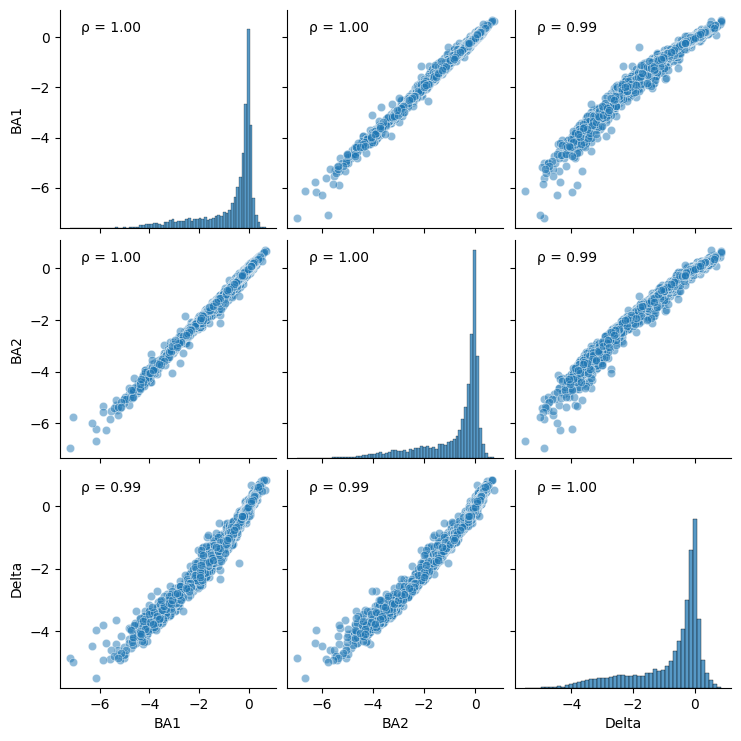

S_Delta


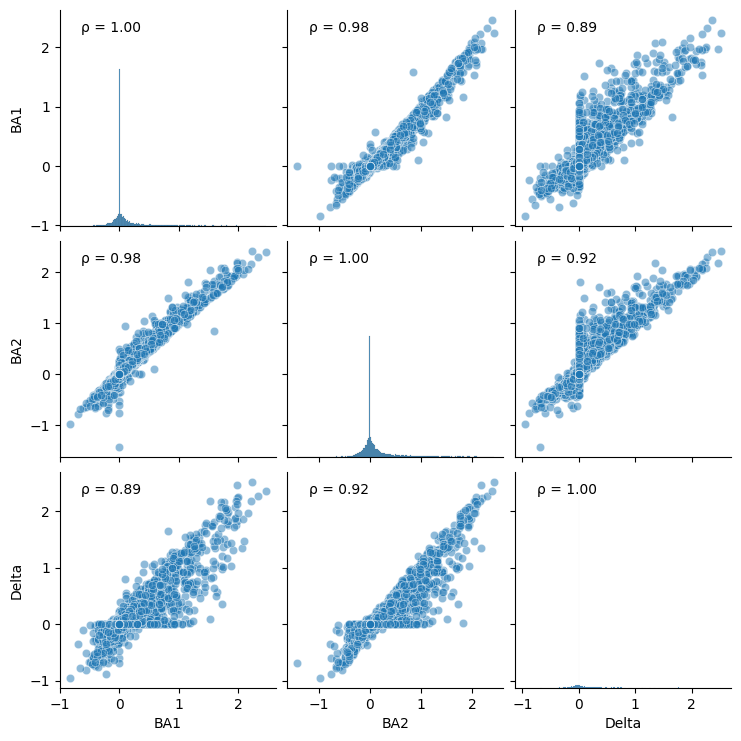

S_Omicron_BA2


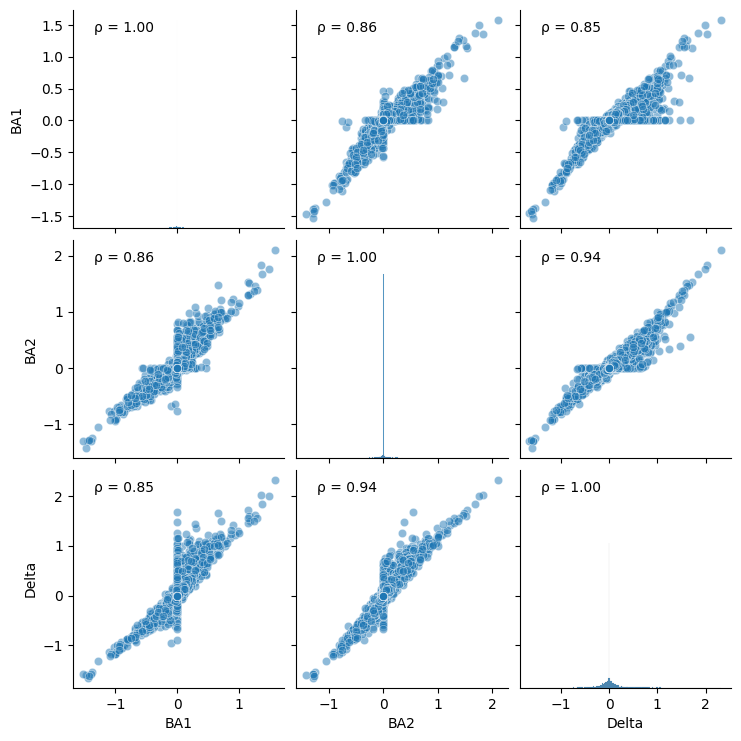

In [12]:
for value in ["β_Omicron_BA1", "S_Delta", "S_Omicron_BA2"]:

    print(value)
    g = sns.pairplot(
        data = relative_params.pivot(
            columns = "reference",
            values = value
        ).dropna(),
        plot_kws=dict(alpha=0.5)# marker="+", linewidth=1),
    )
    
    g.map(corrfunc)
    plt.show()

In [13]:
relative_params

,β_Omicron_BA1,S_Delta,S_Omicron_BA2,reference
mutation,,,,
M1I,-3.392746,0.000000,0.000000,Delta
F2L,0.228677,0.000000,-0.064132,Delta
F2S,0.143352,0.000000,0.000000,Delta
F2V,0.314621,0.000000,0.000000,Delta
V3A,-0.054190,-0.014244,-0.014244,Delta
...,...,...,...,...
S1252T,-0.152548,-0.028114,-0.028114,BA2
S1252V,0.151697,0.025453,-0.061956,BA2
S1252W,0.181581,0.000000,0.000000,BA2


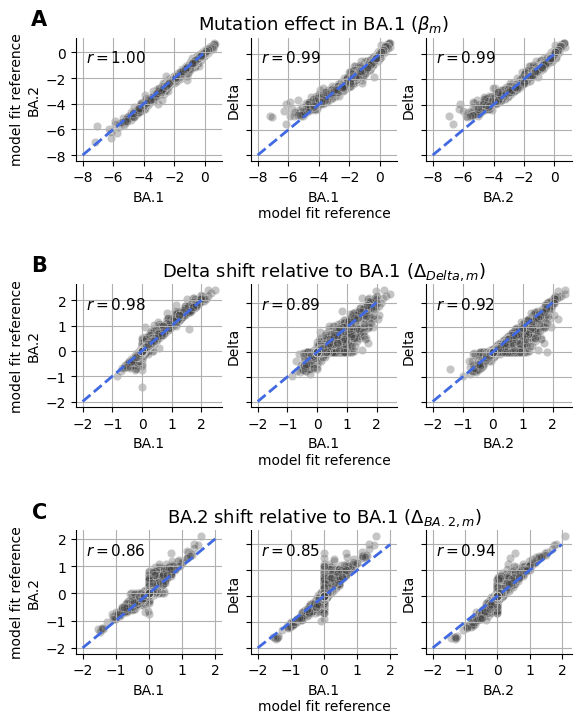

In [14]:
saveas = "reference_model_comparison_params_scatter"
parameters = ["β_Omicron_BA1", "S_Delta", "S_Omicron_BA2"]


fig = plt.figure( figsize=[6.4, 8])
axs = fig.subplot_mosaic(
    [[f"{param}_{col}" for col in range(3)] for param in parameters],
#     empty_sentinel="."
#     height_ratios=[],
#     width_ratios=[],
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 1.0,
    }
)

param_limits = {
    "β_Omicron_BA1" : range(-8, 2, 2),
    "S_Delta" : range(-2, 3),
    "S_Omicron_BA2" : range(-2, 3) 
}

param_titles = {
    "β_Omicron_BA1" : r"Mutation effect in BA.1 ($\beta_m$)",
    "S_Delta" : "Delta shift relative to BA.1 ($\Delta_{Delta,m}$)",
    "S_Omicron_BA2" : "BA.2 shift relative to BA.1 ($\Delta_{BA.2,m}$)"
}


for row, param in enumerate(parameters):
    
    # pivot to each fit on columns, drop NIS.
    data = relative_params.pivot(
        columns = "reference",
        values = param
    ).dropna()

    # plot each combination of fits
    for col, (x, y) in enumerate(combinations(data.columns, 2)):
        iter_ax = axs[f"{param}_{col}"]
        
        sns.scatterplot(
            data = data,
            x = x,
            y = y,
            ax = iter_ax,
            alpha=0.3,
            c='0.25'
        )
        
        corr = pearsonr(data[x], data[y])[0]
        iter_ax.annotate(
            f"$r = {corr:.2f}$", 
            (0.07, 0.8), 
            xycoords="axes fraction", 
            fontsize=11
        )
        
        limits = param_limits[param]
        iter_ax.set_yticks(limits)
        iter_ax.set_xticks(limits)
        mmin, mmax = min(limits), max(limits)
        iter_ax.plot([mmin, mmax], [mmin, mmax], "--", lw=2, c="royalblue")
        label_fn = lambda x: x if x == "Delta" else f"{x[0]}{x[1]}.{x[2]}"
        
        
        xl = f"{label_fn(x)}"
        yl = f"{label_fn(y)}"
        if col == 1: xl += "\nmodel fit reference"
        if col == 0: yl = "model fit reference\n" + yl
        iter_ax.set_xlabel(xl)
        iter_ax.set_ylabel(yl)            
            
        
        
        iter_ax.grid()
        sns.despine(ax = iter_ax)
        
        if col != 0:
            iter_ax.tick_params("y", labelleft=False)
            
        if col == 1:
            iter_ax.set_title(param_titles[param], size=13)
            


for param, sub_anno in zip(parameters, ["A", "B", "C"]):
    iter_ax = axs[f"{param}_0"]    
    axs[f"{param}_0"].text(
        -0.2, 1.15, 
        sub_anno, 
        ha="right", va="center", 
        size=15,
        weight="bold",
        transform=iter_ax.transAxes
    )

fig.savefig(f"{FIG_OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{FIG_OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()